# 1. Pre-processing

#### 1.1. Text Pre-processing

The dataset is already lowercased and lacks punctuation. We will tokenize the text and remove stopwords, as well as apply lemmatization to the tokens.

In [23]:
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import gensim
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

from sklearn.feature_extraction import text

#words to keep: no couldnt cry not cant cannot nor except nobody off but serious enough nothing alone down only without


data = pd.read_json('./data/data.jsonl', lines=True)


def pre_process_data(dataset):
    #tokenize
    dataset['text'] = dataset['text'].apply(nltk.word_tokenize)

    #remove stop words
    my_stop_words = text.ENGLISH_STOP_WORDS
    words_to_keep = frozenset(['no', 'couldnt', 'cry', 'not', 'cant', 'cannot', 'nor', 'except', 'nobody', 'off', 'but', 'serious', 'enough', 'nothing', 'alone', 'down', 'only', 'without'])
    my_stop_words = my_stop_words - words_to_keep
    
    dataset['text'] = dataset['text'].apply(lambda x: [word for word in x if word not in my_stop_words])

    #lemmatize
    lemmatizer = WordNetLemmatizer()
    dataset['text'] = dataset['text'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
    
    return dataset

data = pre_process_data(data)
data.head()

C:\Users\fabio\AppData\Local\Temp\ipykernel_37480\3172380938.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\fabio\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


,text,label
0,"[feel, awful, s, job, position, succeed, just,...",0
1,"[im, alone, feel, awful]",0
2,"[ive, probably, mentioned, but, really, feel, ...",1
3,"[feeling, little, low, day]",0
4,"[beleive, sensitive, people, feeling, tend, co...",2


In [24]:
test_data = pd.read_json('./data/test.jsonl', lines=True)
train_data = pd.read_json('./data/train.jsonl', lines=True)
validation_data = pd.read_json('./data/validation.jsonl', lines=True)

test_data = pre_process_data(test_data)
train_data = pre_process_data(train_data)
validation_data = pre_process_data(validation_data)
print(test_data['text'][13])

print(test_data["text"])

['just', 'feel', 'extremely', 'comfortable', 'group', 'people', 'dont', 'need', 'hide']
0        [im, feeling, rotten, im, not, ambitious, right]
1                      [im, updating, blog, feel, shitty]
2       [make, separate, don, t, want, feel, like, m, ...
3       [left, bouquet, red, yellow, tulip, arm, feeli...
4                            [feeling, little, vain, did]
                              ...                        
1995    [just, feeling, like, unkind, doing, wrong, th...
1996    [im, feeling, little, cranky, negative, doctor...
1997    [feel, useful, people, give, great, feeling, a...
1998    [im, feeling, comfortable, derby, feel, start,...
1999    [feel, weird, meet, w, people, text, but, like...
Name: text, Length: 2000, dtype: object


# 2. Vectorization
(secção possívelmente temporária, mas queria experimentar as cenas de tf_idf depois do pré-processamento) -- matos
não acho que convenha ser temporaria, dado que efetivamente melhora os resultados ihihihi, e é uma prática comum e recomendada pelo que estivemos a ver -- ines


### TF-IDF

#### Hypertunning for tf-idf

In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer




def tfidfVectorizer(data, train_data, validation_data, test_data):
    vectorizer = TfidfVectorizer(stop_words=list(my_stop_words), ngram_range=(1,2), max_features=40000)
    # good idea to use two-grams??
    # print(X.shape)

    x_train = vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']
    
    # print(vectorizer.get_feature_names_out())

    return x_train, x_val, x_test, y_train, y_val, y_test



### BOW model
Count vectorizer which is an implementation of the BOW model.

The disadvantage of the BOW model is it does not consider the sequence of words, and as language does involve sequence and context, sometimes the BOW model might not be a good fit for the best-case scenario.

In [26]:
from sklearn.feature_extraction.text import CountVectorizer

def countVectorizer(data, train_data, validation_data, test_data):
    # Initialize CountVectorizer
    vectorizer = CountVectorizer(stop_words=my_stop_words, ngram_range=(1,2), max_features=40000)

    x_train= vectorizer.fit_transform(train_data['text'].apply(lambda x: ' '.join(x)))

    x_val = vectorizer.transform(validation_data['text'].apply(lambda x: ' '.join(x)))
    x_test = vectorizer.transform(test_data['text'].apply(lambda x: ' '.join(x)))

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



### Doc 2 Vec

#### Document 2 Vector training

In [65]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils

def train_doc2vec(train_data):
    max_epochs = 100
    vec_size = 20
    alpha = 0.025

    tagged_data = [TaggedDocument(words=doc, tags=[str(label)]) for doc, label in zip(train_data['text'], train_data['label'])]

    model = Doc2Vec(vector_size=vec_size,
                    alpha=alpha,
                    min_alpha=0.00025,
                    min_count=1,
                    dm=1)
    
    model.build_vocab(tagged_data)

    model.train(tagged_data, total_examples=model.corpus_count, epochs=50)
    print(model.epochs)
    model.save("d2v_v50.model")
    print("Model Saved")

    return model

train_doc2vec(train_data)

50
Model Saved


In [31]:
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from sklearn import utils
from gensim.models.doc2vec import Doc2Vec

def doc2vec(data, train_data, validation_data, test_data):

    # training the doc2vec model
    #model = train_doc2vec(train_data)
    model = Doc2Vec.load("d2v_v3.model")
    
    x_train = [model.infer_vector(doc) for doc in train_data['text']]
    x_val = [model.infer_vector(doc) for doc in validation_data['text']]
    x_test = [model.infer_vector(doc) for doc in test_data['text']]

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test

### Word 2 Vec

In [23]:
from gensim.models import Word2Vec
import numpy as np

def lala(model, data):
    vectors = []
    for doc in data['text']:
        document = []
        for word in doc:
            if word in model.wv:
                document.append(model.wv[word])
        vectors.append(document)
    return vectors

# test [d,c,c]  | label
########################
## test 
## [ [] [] [] ] | label

def wordEmbeddingsVectorizer(data):

    data_model = Word2Vec(data["text"], vector_size=3, window=10, min_count=2, workers=10, sg=1)
    
    x_train = lala(data_model, train_data)
    x_val =lala(data_model, validation_data)
    x_test = lala(data_model, test_data)

    y_train = train_data['label']
    y_val = validation_data['label']
    y_test = test_data['label']

    return x_train, x_val, x_test, y_train, y_val, y_test



In [32]:
# Choose vectorizer (featurizer)
x_train, x_val, x_test, y_train, y_val, y_test = tfidfVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = countVectorizer(data, train_data, validation_data, test_data)
#x_train, x_val, x_test, y_train, y_val, y_test = wordEmbeddingsVectorizer(data)
#x_train, x_val, x_test, y_train, y_val, y_test = doc2vec(data, train_data, validation_data, test_data)

#print(x_train)

## Apply SMOTE
smote = SMOTE(random_state=42, sampling_strategy='auto', k_neighbors=10)
x_train, y_train = smote.fit_resample(x_train, y_train)



# 3. Model Training

#### 3.1. Model Selection
Aqui também só estava a querer espetar modelos para começar a ver o que dá que ainda não sei que features vão ser usadas:
tf-idf, word embeddings, ???, features mais feitas à mão?


Isto pelos vistos é uma cena, que não implementei (ainda..)

"The validation set uses a subset of the training data to provide an unbiased evaluation of a model. The validation data set contrasts with training and test sets in that it is an intermediate phase used for choosing the best model and optimizing it. It is in this phase that hyperparameter tuning occurs."

Wikipedia:
The basic process of using a validation data set for model selection (as part of training data set, validation data set, and test data set) is:

Since our goal is to find the network having the best performance on new data, the simplest approach to the comparison of different networks is to evaluate the error function using data which is independent of that used for training. Various networks are trained by minimization of an appropriate error function defined with respect to a training data set. The performance of the networks is then compared by evaluating the error function using an independent validation set, and the network having the smallest error with respect to the validation set is selected. This approach is called the hold out method. Since this procedure can itself lead to some overfitting to the validation set, the performance of the selected network should be confirmed by measuring its performance on a third independent set of data called a test set.

An application of this process is in early stopping, where the candidate models are successive iterations of the same network, and training stops when the error on the validation set grows, choosing the previous model (the one with minimum error).

##### 3.1.1. Logistic Regression

In [34]:
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

logreg_classifier = LogisticRegression(max_iter=1000, )
logreg_classifier.fit(x_train, y_train)
y_pred = logreg_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))

0.681
              precision    recall  f1-score   support

           0       0.76      0.75      0.75       550
           1       0.85      0.68      0.76       704
           2       0.50      0.58      0.54       178
           3       0.66      0.67      0.66       275
           4       0.53      0.64      0.58       212
           5       0.32      0.56      0.40        81

    accuracy                           0.68      2000
   macro avg       0.60      0.65      0.62      2000
weighted avg       0.71      0.68      0.69      2000

[[412  23  16  42  38  19]
 [ 58 481  64  26  41  34]
 [ 15  28 104   8  11  12]
 [ 24  15  13 185  23  15]
 [ 25  11   9  15 135  17]
 [  8  11   3   6   8  45]]


##### 3.1.2. Multinomial Naive Bayes

In [35]:

mnb_classifier = MultinomialNB()
mnb_classifier.fit(x_train, y_train)
y_pred = mnb_classifier.predict(x_val)
print(accuracy_score(y_val, y_pred))
print(classification_report(y_val, y_pred))
print(confusion_matrix(y_val, y_pred))



ValueError: Negative values in data passed to MultinomialNB (input X)

## SVM


In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

svm_classifier = SVC(kernel='linear', probability=True, random_state=42)
svm_classifier.fit(x_train, y_train)
y_pred = svm_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

## KNN

In [36]:
from sklearn.neighbors import KNeighborsClassifier

knn_classifier = KNeighborsClassifier(n_neighbors=5)
knn_classifier.fit(x_train, y_train)
y_pred = knn_classifier.predict(x_val)

# Evaluate the performance
accuracy = accuracy_score(y_val, y_pred)
report = classification_report(y_val, y_pred)
conf_matrix = confusion_matrix(y_val, y_pred)

# Print the evaluation metrics
print("Accuracy:", accuracy)
print("Classification Report:\n", report)
print("Confusion Matrix:\n", conf_matrix)

Accuracy: 0.6115
Classification Report:
               precision    recall  f1-score   support

           0       0.70      0.69      0.69       550
           1       0.81      0.63      0.71       704
           2       0.40      0.49      0.44       178
           3       0.56      0.57      0.57       275
           4       0.42      0.55      0.48       212
           5       0.29      0.48      0.36        81

    accuracy                           0.61      2000
   macro avg       0.53      0.57      0.54      2000
weighted avg       0.65      0.61      0.62      2000

Confusion Matrix:
 [[377  29  24  48  47  25]
 [ 64 445  78  44  42  31]
 [ 12  33  88  14  19  12]
 [ 41  18  11 158  39   8]
 [ 33  14  15  15 116  19]
 [ 12  12   2   4  12  39]]


### Boosting Algorithms

Testing with some boosting algorithms

##### XGBOOST

In [ ]:
import xgboost as xgb
# XGBoost Classifier
xgb_classifier = xgb.XGBClassifier()
xgb_classifier.fit(x_train, y_train)
y_pred_xgb = xgb_classifier.predict(x_val)

# Evaluate the performance for XGBoost
accuracy_xgb = accuracy_score(y_val, y_pred_xgb)
report_xgb = classification_report(y_val, y_pred_xgb)
conf_matrix_xgb = confusion_matrix(y_val, y_pred_xgb)

# Print the evaluation metrics for XGBoost
print("XGBoost Classifier Evaluation:")
print("Accuracy:", accuracy_xgb)
print("Classification Report:\n", report_xgb)
print("Confusion Matrix:\n", conf_matrix_xgb)

##### Lightgbm

In [ ]:
import lightgbm as lgb

lgb_classifier = lgb.LGBMClassifier()
lgb_classifier.fit(x_train, y_train)
y_pred_lgb = lgb_classifier.predict(x_val)

# Evaluate the performance for LightGBM
accuracy_lgb = accuracy_score(y_val, y_pred_lgb)
report_lgb = classification_report(y_val, y_pred_lgb)
conf_matrix_lgb = confusion_matrix(y_val, y_pred_lgb)

# Print the evaluation metrics for LightGBM
print("\nLightGBM Classifier Evaluation:")
print("Accuracy:", accuracy_lgb)
print("Classification Report:\n", report_lgb)
print("Confusion Matrix:\n", conf_matrix_lgb)

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

# AdaBoost Classifier
adaboost_classifier = AdaBoostClassifier()
adaboost_classifier.fit(x_train, y_train)
y_pred_adaboost = adaboost_classifier.predict(x_val)

# Evaluate the performance for AdaBoost
accuracy_adaboost = accuracy_score(y_val, y_pred_adaboost)
report_adaboost = classification_report(y_val, y_pred_adaboost)
conf_matrix_adaboost = confusion_matrix(y_val, y_pred_adaboost)

# Print the evaluation metrics for AdaBoost
print("AdaBoost Classifier Evaluation:")
print("Accuracy:", accuracy_adaboost)
print("Classification Report:\n", report_adaboost)
print("Confusion Matrix:\n", conf_matrix_adaboost)


###  Bagging Algorithm

# 5. Model Evaluation

In [42]:
# evaluate with test set
y_pred = logreg_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

y_pred_logreg = logreg_classifier.predict(x_test)

0.706
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       581
           1       0.82      0.74      0.78       695
           2       0.48      0.62      0.54       159
           3       0.63      0.65      0.64       275
           4       0.61      0.66      0.64       224
           5       0.36      0.61      0.45        66

    accuracy                           0.71      2000
   macro avg       0.62      0.67      0.64      2000
weighted avg       0.73      0.71      0.71      2000

[[431  41  26  41  30  12]
 [ 30 515  55  34  31  30]
 [ 13  26  98   9   9   4]
 [ 22  26  14 180  18  15]
 [ 26  13   9  18 148  10]
 [  6   5   4   5   6  40]]


In [38]:
y_pred = mnb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

AttributeError: 'MultinomialNB' object has no attribute 'feature_log_prob_'

In [39]:
y_pred = svm_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


NameError: name 'svm_classifier' is not defined

In [ ]:
y_pred = xgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))


In [ ]:
y_pred = lgb_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [ ]:
y_pred = adaboost_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

In [40]:
y_pred = knn_classifier.predict(x_test)
print(accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

0.618
              precision    recall  f1-score   support

           0       0.72      0.62      0.67       581
           1       0.78      0.66      0.71       695
           2       0.37      0.58      0.45       159
           3       0.53      0.60      0.56       275
           4       0.51      0.56      0.53       224
           5       0.31      0.52      0.39        66

    accuracy                           0.62      2000
   macro avg       0.54      0.59      0.55      2000
weighted avg       0.65      0.62      0.63      2000

[[362  57  35  63  44  20]
 [ 47 458  82  38  42  28]
 [ 13  31  92  10   8   5]
 [ 40  24  16 165  19  11]
 [ 32  12  18  27 125  10]
 [  7   7   3   9   6  34]]


# Cause of errors

In [48]:
emotions_to_int = {
    'sadness': 0,
    'joy': 1,
    'love': 2,
    'anger': 3,
    'fear': 4,
    'surprise': 5
}

int_to_emotions = {v: k for k, v in emotions_to_int.items()}


wrong_predictions = y_test[y_test != y_pred_logreg].index
for i, index in enumerate(wrong_predictions):
    if i == 10:
        break
    print(test_data['text'][index])
    print('Real: ', int_to_emotions[test_data['label'][index]])
    print('Pred:', int_to_emotions[y_pred_logreg[index]])
    print('\n')



['im', 'feeling', 'rather', 'rotten', 'im', 'ambitious', 'right']
Real:  sadness
Pred: love


['cant', 'walk', 'shop', 'anywhere', 'feel', 'uncomfortable']
Real:  fear
Pred: love


['felt', 'anger', 'end', 'telephone', 'call']
Real:  anger
Pred: joy


['like', 'breathless', 'feeling', 'reader', 'eager', 'see', 'happen', 'next']
Real:  joy
Pred: surprise


['feel', 'particularly', 'agitated']
Real:  fear
Pred: sadness


['feel', 'beautifully', 'emotional', 'knowing', 'woman', 'knew', 'handful', 'holding', 'baba', 'journey']
Real:  sadness
Pred: love


['pay', 'attention', 'deepens', 'feeling', 'invaded', 'helpless']
Real:  fear
Pred: sadness


['feel', 'bcoz', 'fight', 'get', 'mad', 'n', 'u', 'wan', 'na', 'make', 'publicity', 'n', 'let', 'world', 'know', 'fight']
Real:  anger
Pred: surprise


['im', 'sure', 'feeling', 'loss', 'ever', 'go', 'away', 'may', 'dull', 'sweet', 'feeling', 'nostalgia', 'shared', 'life', 'dad', 'luck', 'dad', 'year']
Real:  sadness
Pred: love


['survey', 'post'

In [79]:
print(confusion_matrix(y_test, y_pred_logreg))
print(classification_report(y_test, y_pred_logreg))

[[431  41  26  41  30  12]
 [ 30 515  55  34  31  30]
 [ 13  26  98   9   9   4]
 [ 22  26  14 180  18  15]
 [ 26  13   9  18 148  10]
 [  6   5   4   5   6  40]]
              precision    recall  f1-score   support

           0       0.82      0.74      0.78       581
           1       0.82      0.74      0.78       695
           2       0.48      0.62      0.54       159
           3       0.63      0.65      0.64       275
           4       0.61      0.66      0.64       224
           5       0.36      0.61      0.45        66

    accuracy                           0.71      2000
   macro avg       0.62      0.67      0.64      2000
weighted avg       0.73      0.71      0.71      2000


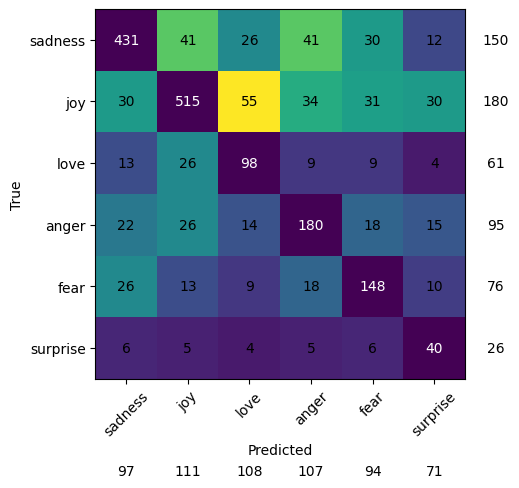

In [78]:
# check which emotions are being confused
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
conf_matrix_copy = conf_matrix.copy()
for i in range(conf_matrix.shape[0]):
    conf_matrix[i, i] = 0 # make the diagonal null, to not eclipse the other values
    
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')
# annotate the axes with the emotion names
plt.xticks(range(6), int_to_emotions.values(), rotation=45)
plt.yticks(range(6), int_to_emotions.values())
# add colorbar more to the right
# plt.colorbar()
# legend the axes with predicted and true values
plt.xlabel('Predicted')
plt.ylabel('True')

# add counts in the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == j:
            plt.text(j, i, conf_matrix_copy[i, j], ha='center', va='center', color='white')
        else:
            plt.text(j, i, conf_matrix[i, j], ha='center', va='center', color='black')

for i in range(conf_matrix.shape[0]): # this does not count correct predictions
    plt.text(6, i, conf_matrix[i, :].sum(), ha='center', va='center', color='black')
for i in range(conf_matrix.shape[1]):
    plt.text(i, 7, conf_matrix[:, i].sum(), ha='center', va='center', color='black')
plt.show()

The test set appears to be unbalance.
- 'joy' is a lot more mixed with 'love' than the contrary. 
- 'surprise' has a low Precision
- 

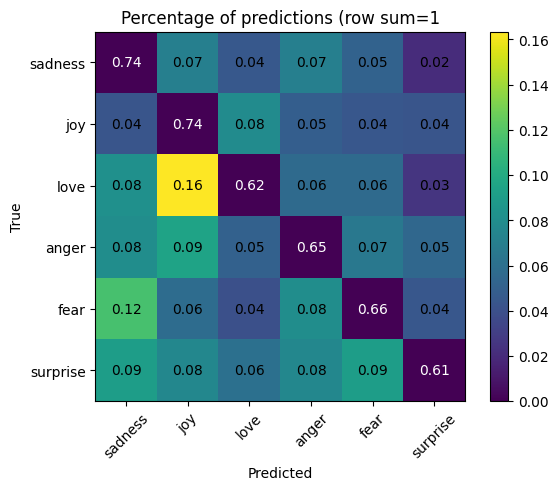

In [97]:
conf_matrix = confusion_matrix(y_test, y_pred_logreg)
conf_matrix = conf_matrix / conf_matrix.sum(axis=1)[:, None] # normalize the confusion matrix
conf_matrix_copy = conf_matrix.copy()
for i in range(conf_matrix.shape[0]):
    conf_matrix[i, i] = 0 # make the diagonal null, to not eclipse the other values
plt.imshow(conf_matrix, cmap='viridis', interpolation='nearest')

plt.xticks(range(6), int_to_emotions.values(), rotation=45)
plt.yticks(range(6), int_to_emotions.values())
plt.colorbar()
plt.xlabel('Predicted')
plt.ylabel('True')

# add counts in the plot
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        if i == j:
            plt.text(j, i, f'{conf_matrix_copy[i, j]:.2f}', ha='center', va='center', color='white')
        else:
            plt.text(j, i, f'{conf_matrix[i, j]:.2f}', ha='center', va='center', color='black')

        
plt.title('Percentage of predictions (row sum=1)')
# Rows add to 1
plt.show()



- sadness mixed with joy and anger
- joy mixed with love
- love mixed with joy
- anger mixed with sadness and joy??
- fear mixed with sadness
- surprise mixed with almost everything